### Import Libraries

In [1]:
# load data
import pandas as pd
import numpy as np
# eda
import matplotlib.pyplot as plt
import plotly.express as plx
import seaborn as sns
# stats test
import scipy.stats as stat
# training and preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
# log models
import mlflow
import optuna

### Import and Visualize data

In [2]:
train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

train = train_data
test = test_data

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [4]:
train.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [5]:
def get_quartiles(data):    
    q3, q1 = np.percentile(data, [75 ,25])
    iqr = q3 - q1
    
    min = q1-iqr*1.5
    if min<0:
        min = data.min()

    print('Lower Bracket: ', min)
    print('q1 : ',q1)
    print('The Interquartile Range for the data is:',iqr)
    print('q3 : ',q3)
    print('Higher Bracket: ', q3+iqr*1.5)
    print('Data lies above Higher Bracket: ', len(data[data>q3+iqr*1.5]))
    print('% of Data can be removed or imputed are: ', (len(data[data>q3+iqr*1.5])/len(data))*100,'%')

### Overview of Target

#### Price

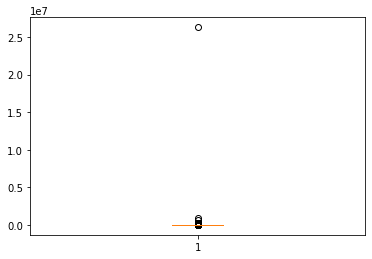

In [6]:
plt.boxplot(train.Price)
plt.show()

**Overview**
- from the above plot we cannot visualize and come into conclusion
- Better option is to see the quartiles of data and come into a conclusion

In [7]:
get_quartiles(train.Price)

Lower Bracket:  1
q1 :  5331.0
The Interquartile Range for the data is: 16744.0
q3 :  22075.0
Higher Bracket:  47191.0
Data lies above Higher Bracket:  1073
% of Data can be removed or imputed are:  5.577792795134377 %


In [8]:
### 0-10 percentage of data having car price
for i in range(11):
    print(i,"%: ",np.percentile(train.Price,[i]))

0 %:  [1.]
1 %:  [45.]
2 %:  [110.]
3 %:  [188.]
4 %:  [251.]
5 %:  [314.]
6 %:  [392.]
7 %:  [392.]
8 %:  [470.]
9 %:  [549.]
10 %:  [627.]


In [9]:
for i in [5,10,20, 30, 40, 50, 60,70,80,90,95, 98, 99]:
    print(i,"%: ",np.percentile(train.Price,[i]))

5 %:  [314.]
10 %:  [627.]
20 %:  [3450.]
30 %:  [7213.]
40 %:  [10036.]
50 %:  [13172.]
60 %:  [16308.]
70 %:  [19757.]
80 %:  [25512.]
90 %:  [38609.]
95 %:  [49459.]
98 %:  [67031.64]
99 %:  [84675.]


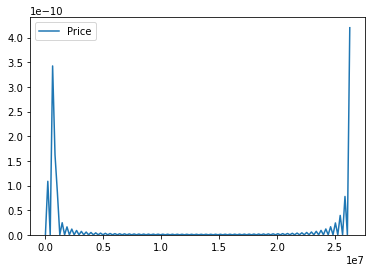

In [10]:
sns.kdeplot(train["Price"])

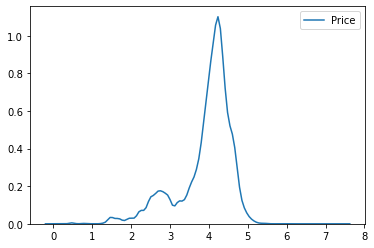

In [11]:
sns.kdeplot(np.log10(train["Price"]))

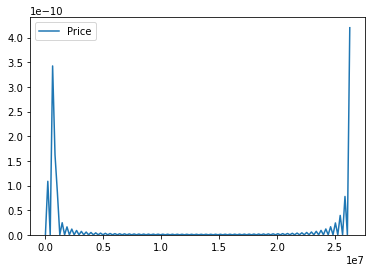

In [12]:
sns.kdeplot(np.exp(np.log(train["Price"])))

**Overview**
- as we can see that 'Price' of 10% of cars in dataset is less than 700, we can treat them as outliers
- as we can see that Data lies above higher price bracket are 1073 i.e 5.6% of total data which can be considered as outliers
- so we can remove the outliers or impute them

### Overview of Features

#### ID

In [13]:
train[['ID','Price']].corr()

,ID,Price
ID,1.000000,-0.000844
Price,-0.000844,1.000000


**Overview**
- as we can see that 'id' has no significant correlation with the target value in the dataset
- so we can remove the specific column from the data

#### Levy

In [14]:
train['Levy'].value_counts()

-       5819
765      486
891      461
639      410
640      405
        ... 
1468       1
5877       1
1662       1
1678       1
1719       1
Name: Levy, Length: 559, dtype: int64

**Observations**
- where '-' signifies no meaning and indicates missing values
- according to the value_count there are 5819('-') among 19237 values in total
- we need to hasndle these missing values using some imputation techniques

#### Manufacturer

In [15]:
car_manu = train.groupby('Manufacturer').count()[['ID']]
car_manu_price = train.groupby('Manufacturer').median()[['Price']]

In [16]:
models = [x.lower() for x in list(car_manu.index)]
print(len(models), len(set(models)))
print(len(models)-len(set(models)))

65 65
0


**Overview**
- There are 65 Manufaturers in whole dataset
- Among which 0 Manufacturers are wrongly imputed

**Investigation after feature importance**

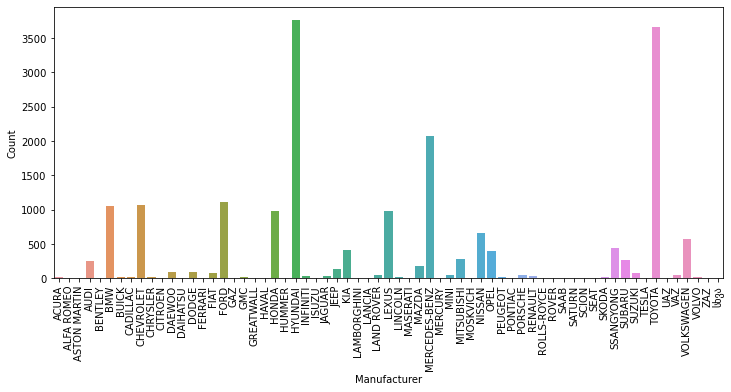

In [17]:
plt.figure(figsize=(12,5))
sns.barplot(x = car_manu.index, y = car_manu.ID)
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.show()

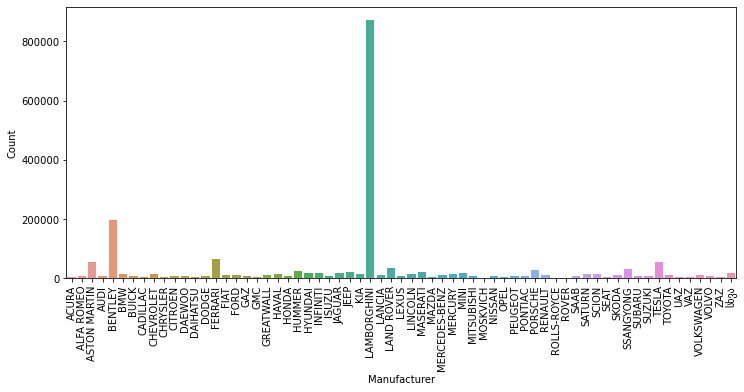

In [18]:
plt.figure(figsize=(12,5))
sns.barplot(x = car_manu_price.index, y = car_manu_price.Price)
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.show()

In [19]:
car_price = car_manu.join(car_manu_price)

In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(max_iter=70, n_clusters=11, n_init=4)
kmeans.fit(car_price).labels_

array([10,  0,  3,  0,  2,  9,  6,  6,  9,  6,  0,  6,  6,  0,  8,  9,  9,
        6, 10,  0,  9,  0,  4,  5,  5,  0,  5,  4,  9,  1,  9,  7,  0,  9,
        4,  6,  0,  9,  5,  0, 10,  0,  6,  0,  6,  4,  0, 10, 10,  6,  9,
        9,  6,  9,  7,  0,  0,  3,  9,  6, 10,  0,  0, 10,  5],
      dtype=int32)

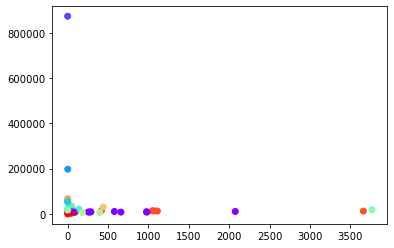

In [21]:
plt.scatter(car_manu,car_manu_price, c=kmeans.labels_, cmap='rainbow')

**Overview**
- as there are huge number of categories i.e 65 and their density is 

In [22]:
car_price['Labels'] = kmeans.fit(car_price).labels_

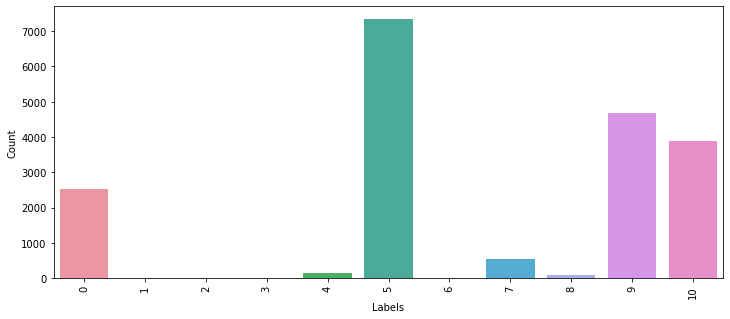

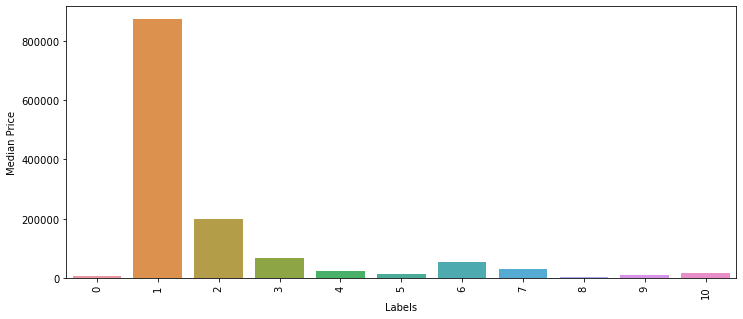

In [23]:
plt.figure(figsize=(12,5))
car_price2 = car_price.groupby('Labels').sum()[['ID']]
sns.barplot(x = car_price2.index, y = car_price2.ID)
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12,5))
car_price2 = car_price.groupby('Labels').median()[['Price']]
sns.barplot(x = car_price2.index, y = car_price2.Price)
plt.xticks(rotation = 90)
plt.ylabel('Median Price')
plt.show()

In [24]:
# Save the labels to the manufacturer dict
manufacturer_dict = dict(zip(car_price.index, [str(i) for i in car_price['Labels']]))

#### Model

In [25]:
car_models = train.groupby('Model').count()[['ID']]
car_models_price = train.groupby('Model').median()[['Price']]

In [26]:
car_models.head()

,ID
Model,
09-Mar,2
100,2
100 NX,1
1000,17
1111,1


In [27]:
models = [x.lower() for x in list(car_models.index)]
print(len(models), len(set(models)))
print(len(models)-len(set(models)))

1590 1511
79


In [28]:
# grouping car models with less production we are left with 
print(len(car_models) - len(car_models[car_models['ID'] == 1]), 'models will be left')

651 models will be left


In [29]:
car_models[car_models['ID'] == 1].index

Index(['100 NX', '1111', '116', '118', '118 2,0', '118 M-sport LCI', '120',
       '128', '128 M tech', '130',
       ...
       'Yaris iA', 'Z4', 'Z4 3,0 SI', 'Zafira B', 'i20', 'i3', 'i40',
       'iA isti', 'kona', 'macan S'],
      dtype='object', name='Model', length=939)

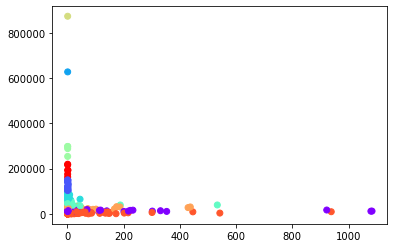

In [30]:
car_model = car_models.join(car_models_price)
kmeans = KMeans(max_iter=70, n_clusters=10, n_init=4)
kmeans.fit(car_model).labels_
car_model['Labels'] = kmeans.labels_
plt.scatter(car_models,car_models_price, c=kmeans.labels_, cmap='rainbow')

In [31]:
models_dict = dict(zip(car_model.index, [str(i) for i in car_model['Labels']]))

**Overview**
- Models having similar names and having typing problem with Upper and Lower letters.
- There are 79 models as such
- Now the total unique models left are 1511 from 1590
- we can group models sold once into a category as 'others' we are left with 651 models

In [32]:
car_models.describe()

,ID
count,1590.000000
mean,12.098742
std,62.955964
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,1083.000000


In [33]:
max_count = car_models.max().values[0]
car_models[car_models['ID'] == max_count]

,ID
Model,
Prius,1083


**Overview**
- we can see that there are 1590 unique models in a dataset of size 19237
- maximum number of datapoints for any model is 1083 which is Prius
- 50% of the models consists only 1 datapoint

#### Production Year

In [34]:
car_production = train.groupby('Prod. year').count()[['ID']]
car_production_price = train.groupby('Prod. year').median()[['Price']]

In [35]:
len(car_production) ## no of years data is stored

54

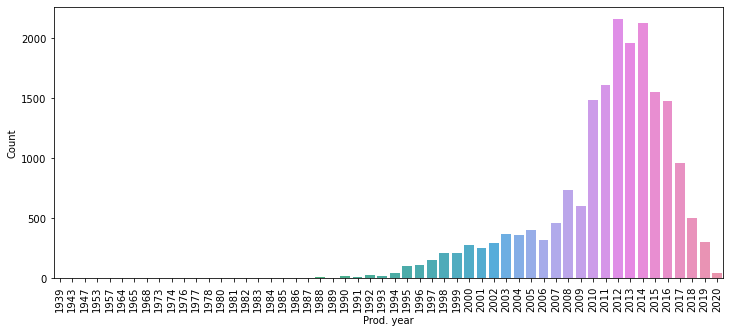

In [36]:
plt.figure(figsize=(12,5))
sns.barplot(x = car_production.index, y = car_production.ID)
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.show()

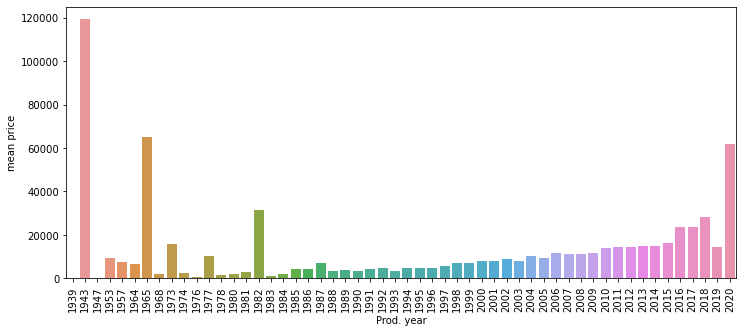

In [37]:
plt.figure(figsize=(12,5))
sns.barplot(x = car_production_price.index, y = car_production_price.Price)
plt.xticks(rotation = 90)
plt.ylabel('mean price')
plt.show()

In [38]:
## highest price of a car
train.Price.max()

26307500

In [39]:
train.Price.median()

13172.0

In [40]:
train_mm = train[train['Prod. year']<=1994]

for i in sorted(train_mm['Prod. year'].unique()):
    train_nn = train_mm[train_mm['Prod. year'] == i].Price
    
    print(i , train_nn.median(), train_nn.mean(), train_nn.shape)

1939 157.0 171.33333333333334 (3,)
1943 119172.0 119172.0 (1,)
1947 150.0 150.0 (1,)
1953 9440.5 17735.25 (4,)
1957 7527.0 7527.0 (1,)
1964 6585.5 6585.5 (2,)
1965 65074.0 65074.0 (2,)
1968 2200.0 2200.0 (1,)
1973 15681.0 15681.0 (1,)
1974 2437.0 2437.0 (2,)
1976 400.0 400.0 (1,)
1977 10340.5 10340.5 (2,)
1978 1400.0 1400.0 (2,)
1980 1925.0 1925.0 (2,)
1981 2800.0 2800.0 (1,)
1982 31361.0 31361.0 (1,)
1983 1200.0 1300.0 (3,)
1984 2000.0 4046.0 (5,)
1985 4200.0 2995.0 (5,)
1986 4155.5 4906.833333333333 (6,)
1987 6899.0 8828.4 (5,)
1988 3381.5 4849.25 (12,)
1989 3606.5 3546.3333333333335 (6,)
1990 3136.0 5215.5 (18,)
1991 4195.5 4746.8 (10,)
1992 4547.5 5677.066666666667 (30,)
1993 3450.0 6407.95652173913 (23,)
1994 4602.0 5968.880952380952 (42,)


**Overview**
- There are 54 years of data stored
- There are very less car data from year 1939 to 1993
- Looks like proper record of car data are kept from year 1995

In [41]:
np.median(np.array(car_production.index))

1993.5

In [42]:
sum1 = car_production[car_production.index <= 1993].sum()
sum2 = car_production[car_production.index > 1993].sum()

In [43]:
print('Car Manufactured from 1939 to 1993 are: ', sum1[0])
print('Car Manufactured from 1994 to 2020 are: ', sum2[0])

Car Manufactured from 1939 to 1993 are:  150
Car Manufactured from 1994 to 2020 are:  19087


**Overview**
- There are 54 years of data stored
- There are very less data from year 1939 to 1993 i.e 150, which can be taken as a whole another year with a lesser number

#### Category

In [44]:
car_category = train.groupby('Category').count()[['ID']].rename(columns = {'ID':'Count'})
car_category_price = train.groupby('Category').median()[['Price']]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

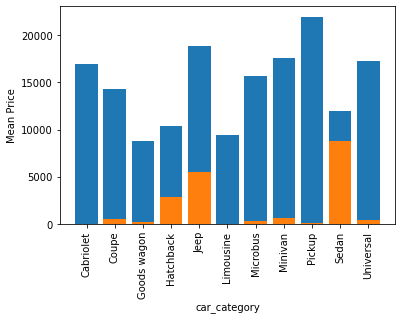

In [45]:
plt.bar(x = car_category_price.index, height = car_category_price['Price'])
plt.bar(x = car_category.index, height = car_category['Count'])
plt.xlabel('car_category')
plt.ylabel('Mean Price')
plt.xticks(rotation = 90)

**Overview**
- orange color tell the count of car data according to type
- There is no correlation to the number of car sold according to category and price

#### Leather Interior

In [46]:
train['Leather interior'].unique()

array(['Yes', 'No'], dtype=object)

#### Fuel Type

In [47]:
train['Fuel type'].unique()

array(['Hybrid', 'Petrol', 'Diesel', 'CNG', 'Plug-in Hybrid', 'LPG',
       'Hydrogen'], dtype=object)

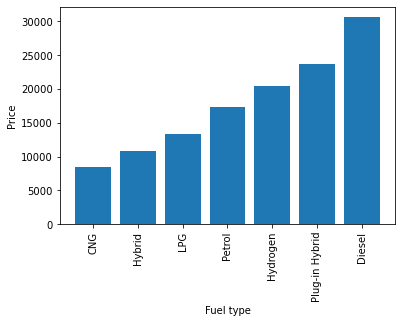

In [48]:
car_fuel_price = train.groupby('Fuel type').mean()[['Price']]
car_fuel_price = car_fuel_price.sort_values(by=['Price'])

plt.bar(x = car_fuel_price.index, height = car_fuel_price['Price'])
plt.xlabel('Fuel type')
plt.ylabel('Price')
plt.xticks(rotation = 90)
plt.show()

**Overview**
- we can visualize mean price of cars are correlated to the fuel type
- which means fuel type will have an effect on price prediction of cars

#### Engine Volume

In [49]:
train['Engine volume'].unique()

array(['3.5', '3', '1.3', '2.5', '2', '1.8', '2.4', '4', '1.6', '3.3',
       '2.0 Turbo', '2.2 Turbo', '4.7', '1.5', '4.4', '3.0 Turbo',
       '1.4 Turbo', '3.6', '2.3', '1.5 Turbo', '1.6 Turbo', '2.2',
       '2.3 Turbo', '1.4', '5.5', '2.8 Turbo', '3.2', '3.8', '4.6', '1.2',
       '5', '1.7', '2.9', '0.5', '1.8 Turbo', '2.4 Turbo', '3.5 Turbo',
       '1.9', '2.7', '4.8', '5.3', '0.4', '2.8', '3.2 Turbo', '1.1',
       '2.1', '0.7', '5.4', '1.3 Turbo', '3.7', '1', '2.5 Turbo', '2.6',
       '1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.8', '0.2 Turbo', '5.7',
       '4.8 Turbo', '4.6 Turbo', '6.7', '6.2', '1.2 Turbo', '3.4',
       '1.7 Turbo', '6.3 Turbo', '2.7 Turbo', '4.3', '4.2', '2.9 Turbo',
       '0', '4.0 Turbo', '20', '3.6 Turbo', '0.3', '3.7 Turbo', '5.9',
       '5.5 Turbo', '0.2', '2.1 Turbo', '5.6', '6', '0.7 Turbo',
       '0.6 Turbo', '6.8', '4.5', '0.6', '7.3', '0.1', '1.0 Turbo', '6.3',
       '4.5 Turbo', '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo', '6.4',
       '3

**Overview**
- Engine volumes are described of two type either normal or turbo
- We can make a seperate column for turbo and seperate for engine volume

#### Mileage

**Observation**
- Mileage is of categorical type so we need to extract the numerical form

#### Cylinders

In [50]:
train['Cylinders'].unique()

array([ 6.,  4.,  8.,  1., 12.,  3.,  2., 16.,  5.,  7.,  9., 10., 14.])

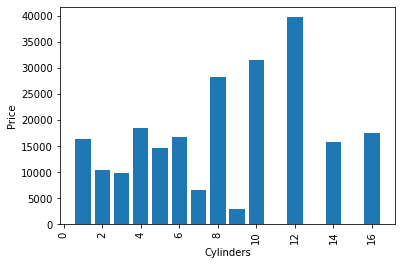

              ID
Cylinders       
1.0           38
2.0           42
3.0          107
4.0        14367
5.0          169
6.0         3462
7.0            4
8.0          991
9.0            1
10.0          12
12.0          38
14.0           1
16.0           5


In [51]:
car_cylinders_price = train.groupby('Cylinders').mean()[['Price']]
car_cylinders_price = car_cylinders_price.sort_values(by=['Price'])

plt.bar(x = car_cylinders_price.index, height = car_cylinders_price['Price'])
plt.xlabel('Cylinders')
plt.ylabel('Price')
plt.xticks(rotation = 90)
plt.show()

print(train.groupby('Cylinders').count()[['ID']])

#### Gear Box Type

In [52]:
train['Gear box type'].unique()

array(['Automatic', 'Tiptronic', 'Variator', 'Manual'], dtype=object)

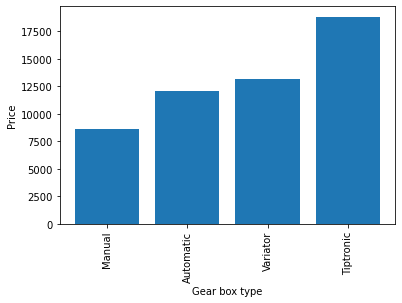

                  ID
Gear box type       
Automatic      13514
Manual          1875
Tiptronic       3102
Variator         746


In [53]:
car_gear_box_price = train.groupby('Gear box type').median()[['Price']]
car_gear_box_price = car_gear_box_price.sort_values(by=['Price'])

plt.bar(x = car_gear_box_price.index, height = car_gear_box_price['Price'])
plt.xlabel('Gear box type')
plt.ylabel('Price')
plt.xticks(rotation = 90)
plt.show()

print(train.groupby('Gear box type').count()[['ID']])

In [54]:
### using stat technique find if the values are linked or indipendent by price
door2 = train[train['Doors'] == '02-Mar']['Price']
door4 = train[train['Doors'] == '04-May']['Price']
door5 = train[train['Doors'] == '>5']['Price']

var2 = door2.std()**2
var4 = door4.std()**2
var5 = door5.std()**2

print('H0: there is no significance difference in group means')
print('H1: there is significant difference in groups')

if var2 != var4 or var4 != var5:
    print('The variances are not same')


if(stat.f_oneway(door2, door4, door5).pvalue > 0.05):
    print('We failed to reject H0')
else :
    print('We accept H1 and reject H0')



H0: there is no significance difference in group means
H1: there is significant difference in groups
The variances are not same
We accept H1 and reject H0


#### Drive Wheels 

In [55]:
train['Drive wheels'].unique()

array(['4x4', 'Front', 'Rear'], dtype=object)

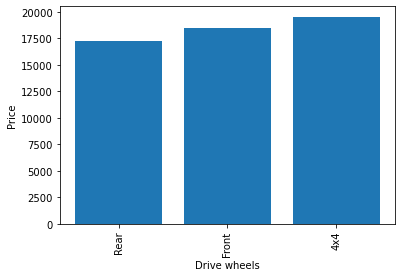

                 ID
Drive wheels       
4x4            4058
Front         12874
Rear           2305


In [56]:
car_Drive_wheels_price = train.groupby('Drive wheels').mean()[['Price']]
car_Drive_wheels_price = car_Drive_wheels_price.sort_values(by=['Price'])

plt.bar(x = car_Drive_wheels_price.index, height = car_Drive_wheels_price['Price'])
plt.xlabel('Drive wheels')
plt.ylabel('Price')
plt.xticks(rotation = 90)
plt.show()

print(train.groupby('Drive wheels').count()[['ID']])

#### Doors

In [57]:
train['Doors'].unique()

array(['04-May', '02-Mar', '>5'], dtype=object)

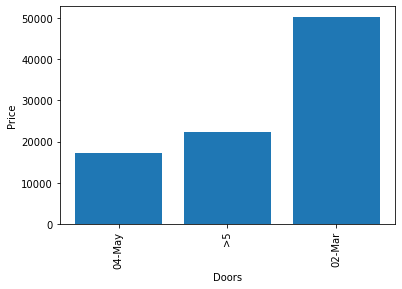

           ID
Doors        
02-Mar    777
04-May  18332
>5        128


In [58]:
car_Doors_price = train.groupby('Doors').mean()[['Price']]
car_Doors_price = car_Doors_price.sort_values(by=['Price'])

plt.bar(x = car_Doors_price.index, height = car_Doors_price['Price'])
plt.xlabel('Doors')
plt.ylabel('Price')
plt.xticks(rotation = 90)
plt.show()

print(train.groupby('Doors').count()[['ID']])

In [59]:
### using stat technique find if the values are linked or indipendent by price
door2 = train[train['Doors'] == '02-Mar']['Price']
door4 = train[train['Doors'] == '04-May']['Price']
door5 = train[train['Doors'] == '>5']['Price']

print('H0: there is no significance difference in group means')
print('H1: there is significant difference in groups')

if(stat.f_oneway(door2, door4, door5).pvalue > 0.05):
    print('We failed to reject H0')
else :
    print('We accept H1 and reject H0')

H0: there is no significance difference in group means
H1: there is significant difference in groups
We accept H1 and reject H0


#### Wheel

In [60]:
train['Wheel'].unique()

array(['Left wheel', 'Right-hand drive'], dtype=object)

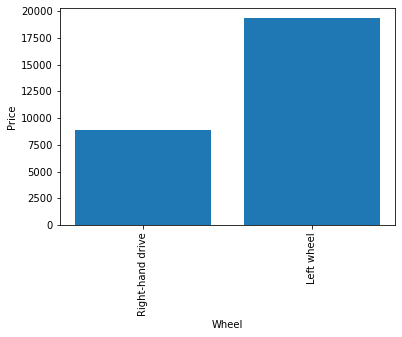

Count of wheel category
                     ID
Wheel                  
Left wheel        17753
Right-hand drive   1484


In [61]:
car_Wheel_price = train.groupby('Wheel').mean()[['Price']]
car_Wheel_price = car_Wheel_price.sort_values(by=['Price'])

plt.bar(x = car_Wheel_price.index, height = car_Wheel_price['Price'])
plt.xlabel('Wheel')
plt.ylabel('Price')
plt.xticks(rotation = 90)
plt.show()

print('Count of wheel category')
print(train.groupby('Wheel').count()[['ID']])

In [62]:
from scipy.stats import f_oneway
 
performance1 = train[train['Wheel'] == 'Right-hand drive']['Price']
performance2 = train[train['Wheel'] == 'Left wheel']['Price']

 
# Conduct the one-way ANOVA
f_oneway(performance1, performance2)

F_onewayResult(statistic=4.128455928822107, pvalue=0.042181524376528605)

**Overview**
- here we reject null hypothesis, where we derive that the two sample means are of same kind.
- we derive that Wheel categories are indipendent with respect to price of the car
- but anova alone cannotprove the difference between two groups, also following up with post-hoc tests

In [63]:
def chi2_independence_testing(data, col1, col2, alpha):
    D_table = pd.crosstab(data[col1], data[col2])
    _, p_val, _, expected = stat.chi2_contingency(D_table)
    if p_val < alpha:
        print(f"p-vlaue {p_val} so we can say that {col1} and {col2} are not independent at {alpha} significance level, i.e features are dependent")
    else:
        print(f"p-vlaue {p_val} so we can say that {col1} and {col2} are independent at {alpha} significance level, i.e features are not dependent")
    return p_val, expected

In [64]:
p_val, table = chi2_independence_testing(train, 'Wheel', 'Doors',0.05)

table

p-vlaue 0.08971501899211887 so we can say that Wheel and Doors are independent at 0.05 significance level, i.e features are not dependent


array([[7.17059885e+02, 1.69178144e+04, 1.18125695e+02],
       [5.99401154e+01, 1.41418558e+03, 9.87430473e+00]])

**Overview**
- here we failed to reject null hypothesis.
- these two features are independent.
- still cannot confidently tell they are independent since our p value is 0.02 greater than 0.05

#### Airbag

In [65]:
train['Airbags'].unique()

array([12,  8,  2,  0,  4,  6, 10,  3,  1, 16,  5,  7,  9, 11, 14, 15, 13])

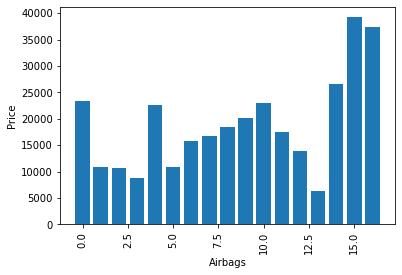

           ID
Airbags      
0        2405
1          76
2        1066
3          37
4        5823
5         104
6        1311
7          86
8        1608
9          63
10        849
11         33
12       5654
13          2
14         20
15          7
16         93


In [66]:
car_Airbags_price = train.groupby('Airbags').mean()[['Price']]

plt.bar(x = car_Airbags_price.index, height = car_Airbags_price['Price'])
plt.xlabel('Airbags')
plt.ylabel('Price')
plt.xticks(rotation = 90)
plt.show()

print(train.groupby('Airbags').count()[['ID']])

## Preprocessing

**Overview**
- according to the previous observation we can make a preprocessing pipeline
- - Input -  Raw data  
- - Output- Preprocessed data, encoder and standardization object which can be used on inference pipeline 

In [67]:
def drop_col(data, col_list):
    if type(col_list) == list:
        return data.drop(columns = col_list)
    else:
        return data.drop(columns = [col_list])

In [88]:
def null_impute(i):
    if i == '-':
        return 0
    else:
        return int(i)
    return data

In [69]:
def get_numbers(data, col):
    data[col].astype('int', inplace=True)
    return data

In [70]:
def Engine_volume(data, col):
    t_list = [] # is turbo list
    v_list = [] # integer volume list
    for i in data[col]:
        volume = i.split()
        if len(volume) > 1:
          t_list.append(1)
        else:
          t_list.append(0)
        v_list.append(float(volume[0]))
    data['Turbo'] = t_list
    data[col] = v_list
    return data

In [71]:
def extract_mileage(x):
    return int(x.split()[0])

In [72]:
def get_quartiles(data, feature,q1,q3):
    q3, q1 = np.percentile(data[feature], [q3 ,q1])
    IQR = q3 - q1
    upper_limit = q3+IQR*1.5
    print('q1:',q1,'q3:',q3)
    print("number of values under upper_quartile: ",len(data[data[feature]<upper_limit]))
    num = len(data) - len(data[data[feature]<upper_limit])
    print('If drop you loose %: ', (num/len(data))*100)
    print('upper: ',upper_limit)
    return (num/len(data))*100, upper_limit

In [73]:
def get_lower(x):
    return x.lower()

In [74]:
def get_models(data, val):
    car_models = data.groupby('Model').count()[['Price']]
    cars = list(car_models[car_models['Price'] <= val].index)
    return cars

In [75]:
tdata = data.copy()

print(tdata.shape)

percent, upper_limit = get_quartiles(tdata, 'Mileage' ,25,75)

# print(upper_limit)
tdata = tdata[tdata['Mileage']<upper_limit]
print(tdata.shape)

NameError: name 'data' is not defined

In [94]:
import pickle
def car_data_preprocessing(data):
    # Dropping the id column
    data = drop_col(data, 'ID')
    
#     # Data features filter
#     data = data[only_important]
    
    # Impute Levy with mean value
    data["Levy"] = data["Levy"].apply(null_impute)
    
    # Engine voume extraction with engine type seperator(is Turbo)
    data = Engine_volume(data, 'Engine volume')
    
    # Extract Mileage
    data['Mileage'] = data['Mileage'].apply(extract_mileage)
    
    # Get the required Mileage
    percent, upper_limit = get_quartiles(data, 'Mileage' ,25,75)
    if percent <= 4:
        data = data[data['Mileage']<upper_limit]
        
    # remove price 
    data = data[data['Price']<np.percentile(data.Price,[95])[0]]
    data = data[data['Price']>np.percentile(data.Price,[5])[0]]
    data["Price"] = np.log(data.Price)
    
    # Lower the model names 
    data['Model'] = data['Model'].apply(get_lower)
    car_list = get_models(data, 1)
    
    '''## third improvement
    data['Model'].replace(model_label)
    ##'''
    with open('model_list.pkl','wb') as file:
        pickle.dump(car_list, file, protocol = pickle.HIGHEST_PROTOCOL)
    
    # second improvement on first Model to increase accuracy
    models = []
    for x in data['Model']:
        if x in car_list:
            models.append('others')
        else:
            models.append(x)

    data['Model'] = models
    ##
    
    ''' ## third improvement
    data['Model'] = data['Model'].replace(model_label)
    ##
    
    ## third improvement
    data['Manufacturer'] = data['Manufacturer'].replace(manu_label)
    ##'''
    
    # encode all categorical columns using label encoder
    cat_columns = data.select_dtypes(include=["object"]).columns
    dict_encoder = {}
    dict_unique_lab = {}
    for i in cat_columns:
        le = LabelEncoder()
        dict_unique_lab[i] = data[i].unique()
        dict_encoder[i] = le.fit(data[i]) 
        data[i] = dict_encoder[i].transform(data[i])
    
    # reset the index that was shuffled due to preprocessing
    data.reset_index(inplace=True)
    data = data.iloc[:,1:]
    
    # standard scalar the numerical data because having large jumps in numbers
    # standardizinng the numbers helps models to understand features properly and get more accurate results
    num_columns = ['Levy', 'Mileage', 'Cylinders','Airbags', 'Engine volume']
    

    scalers= {}
    for col_name in num_columns:
        scaler = StandardScaler()
        scaler.fit(data[col_name].values.reshape(-1,1))
        scalers[col_name] = scaler
    
    return data, dict_encoder, scalers

In [83]:
train.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [95]:
data_train, encoder, scalar = car_data_preprocessing(train)

q1: 70139.0 q3: 188888.0
number of values under upper_quartile:  18597
If drop you loose %:  3.326922077246972
upper:  367011.5


In [96]:
data_train.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
0,9.497622,1399,28,485,2010,4,1,2,3.5,186005,6.0,0,0,1,0,12,12,0
1,9.718422,1018,6,241,2011,4,0,5,3.0,192000,6.0,2,0,1,0,1,8,0
2,9.043932,0,18,259,2006,3,0,5,1.3,200000,4.0,3,1,1,1,1,2,0
3,8.190632,862,13,246,2011,4,1,2,2.5,168966,4.0,0,0,1,0,14,0,0
4,9.369564,446,18,259,2014,3,1,5,1.3,91901,4.0,0,1,1,0,12,4,0


In [147]:
import pickle

with open('Encoder.pkl','wb') as file:
    pickle.dump(encoder, file, protocol = pickle.HIGHEST_PROTOCOL)

with open('Standard_scalars.pkl','wb') as file:
    pickle.dump(scalar, file, protocol = pickle.HIGHEST_PROTOCOL)
    
# with open('model_label.pkl','wb') as file:
#     pickle.dump(models_dict, file, protocol = pickle.HIGHEST_PROTOCOL)
    
# with open('manufacturer_label.pkl','wb') as file:
#     pickle.dump(manufacturer_dict, file, protocol = pickle.HIGHEST_PROTOCOL)

In [706]:
# create clusters

In [707]:
data_train.shape

(16576, 18)

In [97]:
# split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(data_train.drop(columns = ['Price']).values,data_train['Price'].values, test_size=0.2)

In [101]:
dt = DecisionTreeRegressor(max_depth=15)
dt.fit(Xtrain, ytrain)

ypred = dt.predict(Xtrain)

# print("TRAIN R2: ",r2_score(ypred,ytrain))
# print("TEST R2: ",r2_score(dt.predict(Xtest),ytest))

print("TRAIN R2: ",r2_score(np.exp(ytrain), np.exp(ypred)))
print("TEST R2: ",r2_score(np.exp(ytest), np.exp(dt.predict(Xtest))))

TRAIN R2:  0.8862036200138008
TEST R2:  0.6532282816614692


In [105]:
obj = RandomForestRegressor(max_depth=50, n_estimators=500)
obj.fit(Xtrain,ytrain)

print("TRAIN R2: ",r2_score(np.exp(ytrain), np.exp(obj.predict(Xtrain))))
print("TEST R2: ",r2_score(np.exp(ytest), np.exp(obj.predict(Xtest))))

print()

# print("TRAIN RMSE: ",mean_squared_error(np.exp(obj.predict(Xtrain)),ytrain,squared=False))
# print("TEST RMSE: ",mean_squared_error(obj.predict(Xtest),ytest,squared=False))

TRAIN R2:  0.9347535694038644
TEST R2:  0.7645098767235503



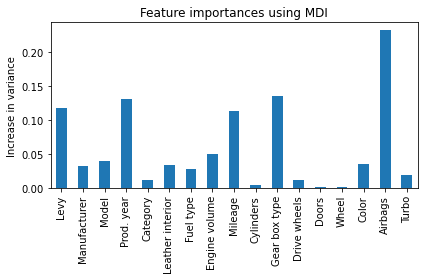

In [104]:
importances = obj.feature_importances_
forest_importances = pd.Series(importances, index=data_train.drop(columns=['Price']).columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel('Increase in variance')
fig.tight_layout()

In [792]:
data_train['Price']

0         9.497622
1         9.718422
2         9.043932
3         8.190632
4         9.369564
           ...    
16571     9.043932
16572     9.660205
16573    10.169997
16574     8.581294
16575     6.152733
Name: Price, Length: 16576, dtype: float64

In [713]:
print('Features contributing more than 90% to the model')

print(forest_importances[forest_importances>0.03])
only_important_features = forest_importances[forest_importances>0.03].index
forest_importances[forest_importances>0.03].sum()

Features contributing more than 90% to the model
Manufacturer        0.032203
Model               0.043193
Prod. year          0.125469
Leather interior    0.048655
Engine volume       0.048748
Gear box type       0.136762
Color               0.032821
Levy                0.097510
Mileage             0.113064
Airbags             0.231370
dtype: float64


0.9097950316340918

**Overview**
- Investing only features contributing most i.e 90% for prediction results

In [717]:
only_important_features = list(only_important_features)

## Get best params using Optuna

In [73]:
import sklearn
from sklearn.model_selection import cross_val_score
import optuna

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 50, log=True)
    estim = trial.suggest_int('estim', 100, 500, log=True)

    obj = RandomForestRegressor(max_depth=rf_max_depth, n_estimators=estim)
    score = cross_val_score(obj, Xtrain, ytrain , n_jobs=-1, cv=4)
    accuracy = score.mean()    
    return accuracy


# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2022-07-12 13:17:11,897] A new study created in memory with name: no-name-c7a5c927-ee1a-449e-963c-0b8ac50d9f17
[I 2022-07-12 13:17:32,719] Trial 0 finished with value: 0.7581539560091903 and parameters: {'rf_max_depth': 47, 'estim': 173}. Best is trial 0 with value: 0.7581539560091903.
[I 2022-07-12 13:18:19,173] Trial 1 finished with value: 0.7587061661181197 and parameters: {'rf_max_depth': 21, 'estim': 373}. Best is trial 1 with value: 0.7587061661181197.
[I 2022-07-12 13:18:28,427] Trial 2 finished with value: 0.32225522387881295 and parameters: {'rf_max_depth': 2, 'estim': 456}. Best is trial 1 with value: 0.7587061661181197.
[I 2022-07-12 13:19:16,036] Trial 3 finished with value: 0.7532804181831869 and parameters: {'rf_max_depth': 16, 'estim': 472}. Best is trial 1 with value: 0.7587061661181197.
[I 2022-07-12 13:19:20,235] Trial 4 finished with value: 0.47075378631507003 and parameters: {'rf_max_depth': 4, 'estim': 132}. Best is trial 1 with value: 0.7587061661181197.
[I 202

In [739]:
import sklearn
from sklearn.model_selection import cross_val_score
import optuna
import xgboost as xgb

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 50, log=True)
    estim = trial.suggest_int('estim', 100, 500, log=True)

    obj = xgb.XGBRegressor(max_depth=rf_max_depth, n_estimators=estim)
    score = cross_val_score(obj, Xtrain, ytrain , n_jobs=-1, cv=4)
    accuracy = score.mean()    
    return accuracy

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2022-07-11 16:59:41,330] A new study created in memory with name: no-name-0119a13e-0e6b-4014-b8c0-e3a2a8bb9ea7
[I 2022-07-11 16:59:56,509] Trial 0 finished with value: 0.7124587988598905 and parameters: {'rf_max_depth': 37, 'estim': 335}. Best is trial 0 with value: 0.7124587988598905.
[I 2022-07-11 17:00:08,997] Trial 1 finished with value: 0.7119573698870885 and parameters: {'rf_max_depth': 31, 'estim': 318}. Best is trial 0 with value: 0.7124587988598905.
[I 2022-07-11 17:00:19,093] Trial 2 finished with value: 0.7101080936139059 and parameters: {'rf_max_depth': 21, 'estim': 179}. Best is trial 0 with value: 0.7124587988598905.
[I 2022-07-11 17:00:39,372] Trial 3 finished with value: 0.7187112608718372 and parameters: {'rf_max_depth': 11, 'estim': 403}. Best is trial 3 with value: 0.7187112608718372.
[I 2022-07-11 17:00:41,273] Trial 4 finished with value: 0.5388713346047758 and parameters: {'rf_max_depth': 2, 'estim': 100}. Best is trial 3 with value: 0.7187112608718372.
[I 2022

## Model Stacking

In [138]:
from sklearn.ensemble import StackingRegressor

estimators = [
  ('rf', RandomForestRegressor(max_depth=33, n_estimators=236)),
  ('xgb', xgb.XGBRegressor(max_depth=7, n_estimators=247))
]
reg_stack = StackingRegressor(estimators=estimators)
reg_stack.fit(Xtrain, ytrain).score(Xtest, ytest)

0.7484481005269963

In [ ]:
import sklearn
from sklearn.model_selection import cross_val_score
import optuna
import xgboost as xgb
import mlflow

estimators = [
  ('rf', RandomForestRegressor(max_depth=33, n_estimators=236)),
  ('xgb', xgb.XGBRegressor(max_depth=7, n_estimators=247))
]

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 50, log=True)
    estim = trial.suggest_int('estim', 100, 500, log=True)
    
    xgb_max_depth = trial.suggest_int('rf_max_depth', 2, 10, log=True)
    xgb_estim = trial.suggest_int('estim', 100, 500, log=True)
    
    estimators = [('rf', RandomForestRegressor(max_depth=rf_max_depth, n_estimators=estim)),
                  ('xgb', xgb.XGBRegressor(max_depth=xgb_max_depth, n_estimators=xgb_estim))]

    reg_stack = StackingRegressor(estimators=estimators)

    score = cross_val_score(reg_stack, Xtrain, ytrain , n_jobs=-1, cv=4)
    accuracy = score.mean()    
    return accuracy




# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# create a dictionary with best parameters and accuracy
dict1 = study.best_params
dict1['CV Accuracy'] = study.best_trial.value
dict1

# sore the best max depth and estimators
rf_max_depth = dict1['rf_max_depth']
estim = dict1['estim']

reg_stack = StackingRegressor(estimators=estimators)
signature = infer_signature(Xtrain, reg_stack.predict(Xtrain))

mlflow.log_param('params_accuracy', dict1)
mlflow.sklearn.log_model(reg_stack, "car_rf", signature=signature)

In [140]:
pred = reg_stack.predict(Xtest)
print(r2_score(np.exp(pred), np.exp(ytest)))
# mlflow.log_param('params_accuracy', dict1)
# mlflow.sklearn.log_model(obj, "car_rf", signature=signature)

0.6825711152028755


#### Bagging Model

In [107]:
import xgboost as xgb

xgb = xgb.XGBRegressor(max_depth=7, n_estimators=247)
xgb.fit(Xtrain, ytrain)
r2_score(np.exp(ytest), np.exp(xgb.predict(Xtest)))

0.6731907147728142

In [106]:
rfb = RandomForestRegressor(max_depth=33, n_estimators=236)
rfb.fit(Xtrain, ytrain)
r2_score(np.exp(ytest), np.exp(rfb.predict(Xtest)))

0.7640064440780661

#### Root Mean Sqared Error

In [803]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(np.exp(ytest), np.exp(rfb.predict(Xtest))))

5976.634182876646

In [ ]:
import shap
explainer = shap.TreeExplainer(rfb)
shap_values = explainer.shap_values(Xtest)

shap.summary_plot(shap_values, Xtest)

#### Storing the best model

In [806]:
with open('best_model.pkl','wb') as file:
    pickle.dump(reg_stack, file, protocol = pickle.HIGHEST_PROTOCOL)

## Inference Pipeline

In [126]:
def car_data_inference(data,sc, dict_encoder, car_list):
    # Dropping the id column
    data = drop_col(data, 'ID')
    data = drop_col(data, 'Price')
#     # Data features filter
#     data = data[only_important]
    
    # Impute Levy with mean value
    data = null_impute_mean(data, 'Levy')
    
    # Engine voume extraction with engine type seperator(is Turbo)
    data = Engine_volume(data, 'Engine volume')
    
    # Extract Mileage
    data['Mileage'] = data['Mileage'].apply(extract_mileage)
    
    # Get the required Mileage
    percent, upper_limit = get_quartiles(data, 'Mileage' ,25,75)
    if percent <= 4:
        data = data[data['Mileage']<upper_limit]
        
    # remove price 
#     data = data[data['Price']<np.percentile(data.Price,[95])[0]]
#     data = data[data['Price']>np.percentile(data.Price,[5])[0]]
#     data["Price"] = np.log(data.Price)
    
    # Lower the model names 
#     data['Model'] = data['Model'].apply(get_lower)
#     car_list = get_models(data, 1)
    
    
    ## second improvement on first Model to increase accuracy
    models = []
    for x in data['Model']:
        if x in car_list:
            models.append('others')
        else:
            models.append(x)

    data['Model'] = models
    ##
    
    ''' ## third improvement
    data['Model'] = data['Model'].replace(model_label)
    ##
    
    ## third improvement
    data['Manufacturer'] = data['Manufacturer'].replace(manu_label)
    ##'''
    
    # encode all categorical columns using label encoder
    cat_columns = data.select_dtypes(include=["object"]).columns
    for i in cat_columns:
        if '<unknown>' not in dict_encoder[i].classes_ :
            data[i] = data[i].map(lambda s: '<unknown>' if s not in dict_encoder[i].classes_ else s)
            dict_encoder[i].classes_ = np.append(dict_encoder[i].classes_, '<unknown>')
        else:
            data[i] = data[i].map(lambda s: '<unknown>' if s not in dict_encoder[i].classes_ 
    for i in cat_columns:
        data[i] = dict_encoder[i].transform(data[i])
    
    # reset the index that was shuffled due to preprocessing
    data.reset_index(inplace=True)
    data = data.iloc[:,1:]
    
    # standard scalar the numerical data because having large jumps in numbers
    # standardizinng the numbers helps models to understand features properly and get more accurate results
    num_columns = ['Levy', 'Mileage', 'Cylinders','Airbags', 'Engine volume']

    scalars = sc.transform(data[num_columns].values)
    data_scalar = pd.DataFrame(scalars , 
                               columns= num_columns)
    
    # drop the actual columns are impute with standardized columns 
    data.drop(columns = num_columns, inplace=True)
    data = data.join(data_scalar)
    
    return data

In [153]:
import pickle
with open('Standard_scalars.pkl', 'rb') as handle:
    standard_scalar = pickle. load(handle)

with open('Encoder.pkl', 'rb') as handle:
    dict_encoder = pickle. load(handle)
    
with open('model_list.pkl', 'rb') as handle:
    car_list = pickle. load(handle)
    
with open('best_model.pkl', 'rb') as handle:
    model = pickle. load(handle)
# with open('manufacturer_label.pkl', 'rb') as handle:
#     manufacturer_label = pickle. load(handle)

In [150]:
car_data_inference(test.iloc[:10], standard_scalar, dict_encoder, car_list)

q1: 60923.75 q3: 169500.0
number of values under upper_quartile:  10
If drop you loose %:  0.0
upper:  332364.375


,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color,Turbo,Levy,Mileage,Cylinders,Airbags,Engine volume
0,55,604,2012,3,0,1,1,1,0,0,7,1,0.259717,-1.629872,-0.464720,0.806377,-0.317142
1,20,604,2012,9,1,5,2,1,1,0,7,0,0.259717,-1.306953,-0.464720,0.806377,0.158212
2,37,604,2005,9,0,5,0,1,1,1,13,0,0.259717,0.456685,-0.464720,0.336362,-0.911335
3,56,604,2012,4,1,5,0,0,1,0,2,0,0.210258,0.146186,1.284416,1.276391,1.108921
4,38,604,1993,3,0,5,1,1,1,0,1,0,0.259717,0.854125,-0.464720,-1.543694,-0.792496
5,3,26,2014,9,1,5,2,2,1,0,1,1,-0.664381,-0.887989,-0.464720,1.276391,-0.317142
6,28,604,2015,4,1,5,0,0,1,0,1,0,1.956932,-0.351769,3.033552,-1.543694,2.772662
7,32,604,2011,9,1,1,0,0,1,0,2,0,0.723067,-0.828833,1.284416,1.276391,1.465437
8,20,604,2016,9,1,4,0,1,1,0,12,0,-0.008402,2.099029,-0.464720,-0.603666,-0.317142
9,9,604,2011,9,1,5,0,1,1,0,14,0,-0.648762,0.481525,-0.464720,-0.603666,-0.554819


## Model Runs Screen shot <a class='anchor' id='Screen-Shots'></a>

- First Run without modification in preprocess pipeline

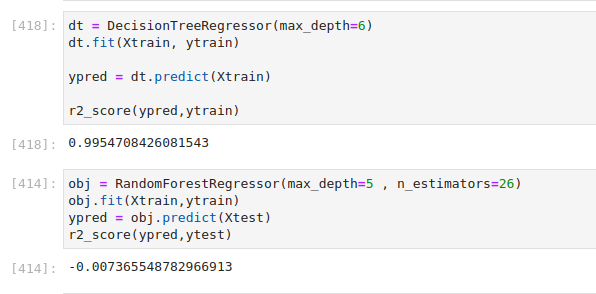

- Second run after second improvemnt

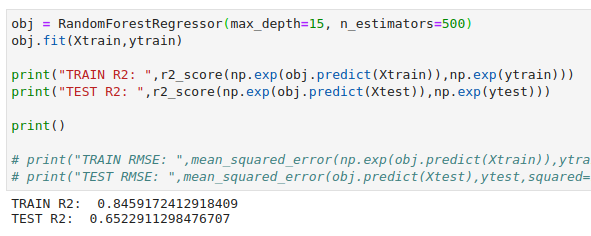

- Third Improvement

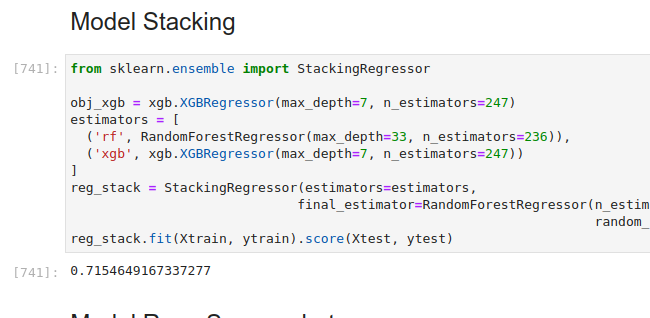

In [164]:
from Inference import Inference_Pipeline

inference = Inference_Pipeline()

import pickle
with open('Standard_scalars.pkl', 'rb') as handle:
    standard_scalar = pickle.load(handle)

with open('Encoder.pkl', 'rb') as handle:
    dict_encoder = pickle.load(handle)
    
with open('model_list.pkl', 'rb') as handle:
    car_list = pickle.load(handle)
    
with open('best_model.pkl', 'rb') as handle:
    model = pickle.load(handle)
    
test = inference.car_data_inference(test,standard_scalar, dict_encoder, car_list)

model.predict(test)

NameError: name 'np' is not defined

In [162]:
!pip freeze > requirenment.txt